In [ ]:
#df['l'] = df['summary'].apply(lambda x: len(str(x).split(' ')))
#print("mean length of sentence: " + str(df.l.mean())) 
#print("max length of sentence: " + str(df.l.max())) 
#words = " ".join(X).split()
#len(words)
#27881

#No Stemming or Stop word removal Stop word removal made no difference
#No Lower lower case lower case made no difference
#Value_counts(), using downsampling, does not work
#Traianble False Does not work so discarded
#Try word2vec

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
import os
import re
import sys
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import keras
from nltk.stem import WordNetLemmatizer 
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from collections import Counter
import nltk

from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras import regularizers

%matplotlib inline

In [ ]:
df = pd.read_csv("pa_sample.csv")

In [ ]:
#data = df.loc[df['topic']=="Technology"]
#df = df.append(data)

In [3]:
Y = df.majortopic.values
le = LabelEncoder()
Y = le.fit_transform(Y)
Y1 = le.fit_transform(Y)
df['topic'] = Y1
num = [i for i in range(max(Y) + 1)]
df = df.loc[df['topic'].isin(num)].groupby('majortopic').head(750)

<BarContainer object of 18 artists>

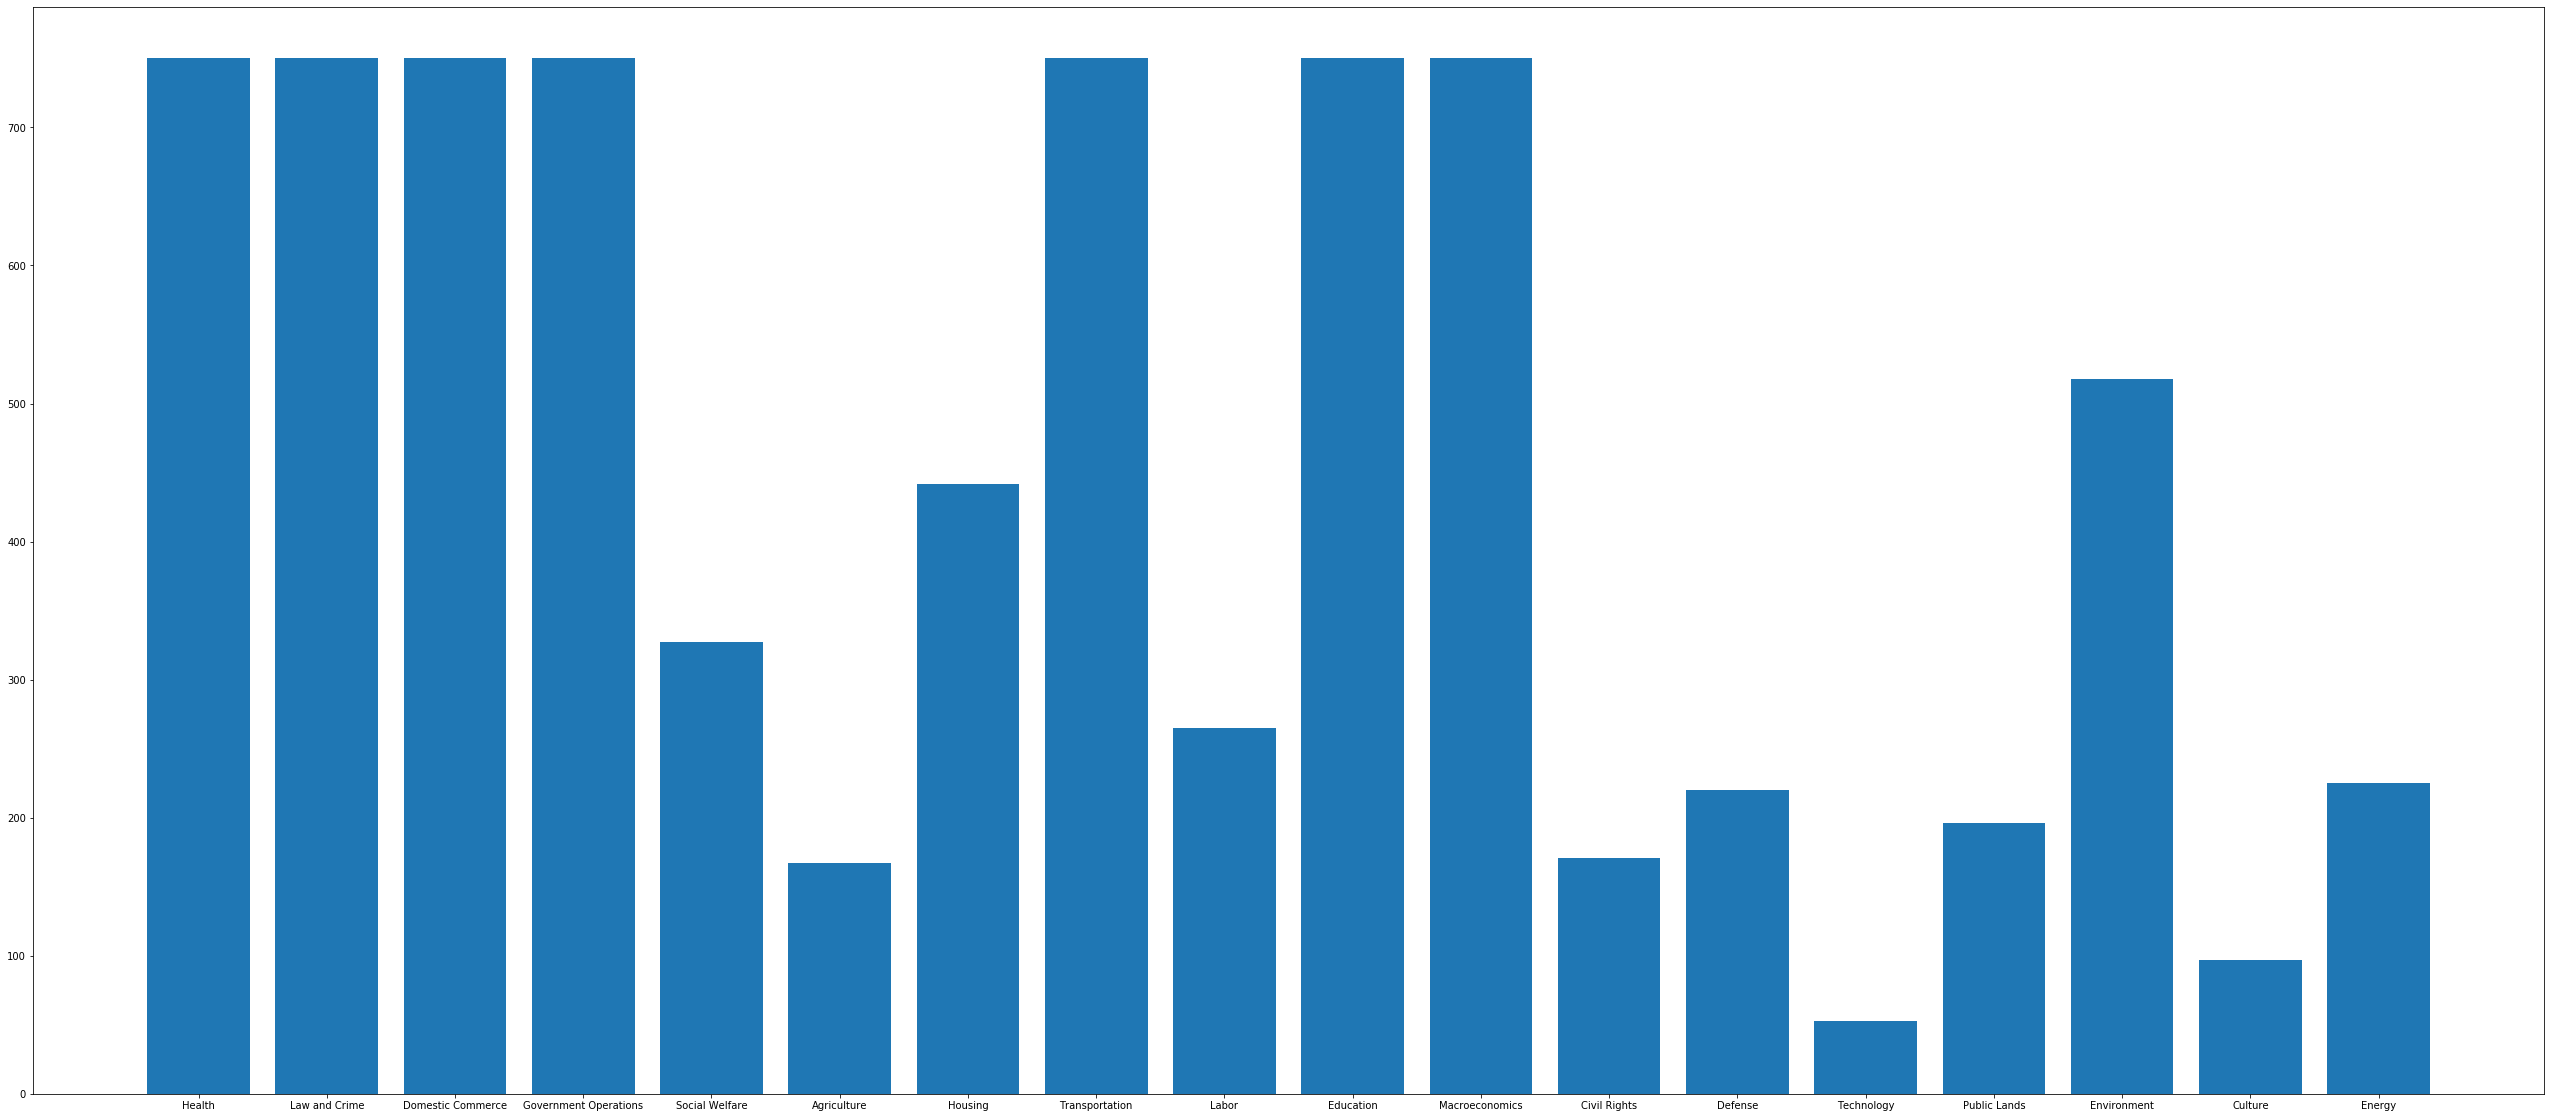

In [4]:
from collections import Counter
a = Counter(df.majortopic)
plt.figure(figsize=(45,20))
plt.bar(a.keys(), a.values())

In [5]:
df.summary = df.summary.str.lower()

In [6]:
df.summary = df.summary.str.replace('[^a-zA-Z ]', ' ')

In [ ]:
#stop = stopwords.words('english')
#stop.extend(['introduced','virginia', 'bill', 'session', 'person' , 'house', 'no','author', 'license', 'local','public','article'
#            'city','county','agency', 'amends','chapter','act','amend','reenact','code','approved','pursuant','designated','chapter',
#            'rule','exercise','criterion','town','subject','prelude','shall','rule','permitted','restricted','regulation',
#            'assembly','state'])

In [ ]:
#results = set()
#df['summary'].str.split().apply(results.update)
#wordsets = frozenset(results)
#results1 = []
#for word in wordsets:
#    count = sum( 1 for s in wordsets if word in s )
#    results1.append((count, word))



In [ ]:
#for count, word in sorted(results1, reverse=True):
#    if count < 20:
#        break
#    if len(word)>3:
#        stop.append(word)

In [7]:
lemmatizer = WordNetLemmatizer() 
df.summary = df.summary.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()] ))

In [8]:
X = df.summary.values
Y = df.majortopic.values

In [9]:
MAX_SEQUENCE_LENGTH = 92 #84 for no stop word removal
MAX_WORDS = 10000
batch_size = 32 
embedding_dim = 100
num_filters = 32

In [10]:
tokenizer  = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, MAX_SEQUENCE_LENGTH)

In [11]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y1 = le.fit_transform(Y)
Y = Y.reshape(-1,1)
Y = to_categorical(Y)

In [12]:
Y1 = np.argmax(Y, axis = 1)

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.10)

In [14]:
checkpoint = ModelCheckpoint('weights.final.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

In [15]:
model = Sequential()
model.add(layers.Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim, input_length=MAX_SEQUENCE_LENGTH))
model.add(layers.Conv1D(64, 3, activation='relu',padding='valid'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(18, activation='softmax'))
model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=1, validation_data = (X_test, y_test) , shuffle=True,
                   callbacks = [checkpoint,EarlyStopping(monitor='val_loss', patience=10)])

C:\Users\prada\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7137 samples, validate on 794 samples
Epoch 1/100
7137/7137 [==============================] - 7s 1ms/step - loss: 2.8604 - accuracy: 0.0836 - val_loss: 2.8038 - val_accuracy: 0.1285

Epoch 00001: val_accuracy improved from -inf to 0.12846, saving model to weights.final.hdf5
Epoch 2/100
7137/7137 [==============================] - 2s 316us/step - loss: 2.7491 - accuracy: 0.1494 - val_loss: 2.6368 - val_accuracy: 0.3564

Epoch 00002: val_accuracy improved from 0.12846 to 0.35642, saving model to weights.final.hdf5
Epoch 3/100
7137/7137 [==============================] - 2s 345us/step - loss: 2.5833 - accuracy: 0.2470 - val_loss: 2.4376 - val_accuracy: 0.3791

Epoch 00003: val_accuracy improved from 0.35642 to 0.37909, saving model to weights.final.hdf5
Epoch 4/100
7137/7137 [==============================] - 2s 325us/step - loss: 2.3965 - accuracy: 0.3228 - val_loss: 2.2394 - val_accuracy: 0.3917

Epoch 00004: val_accuracy improved from 0.37909 to 0.39169, saving model to weigh

7137/7137 [==============================] - 10s 1ms/step - loss: 0.5295 - accuracy: 0.8668 - val_loss: 0.7245 - val_accuracy: 0.8262

Epoch 00035: val_accuracy did not improve from 0.82620
Epoch 36/100
7137/7137 [==============================] - 10s 1ms/step - loss: 0.5169 - accuracy: 0.8669 - val_loss: 0.7120 - val_accuracy: 0.8249

Epoch 00036: val_accuracy did not improve from 0.82620
Epoch 37/100
7137/7137 [==============================] - 10s 1ms/step - loss: 0.5050 - accuracy: 0.8672 - val_loss: 0.7057 - val_accuracy: 0.8237

Epoch 00037: val_accuracy did not improve from 0.82620
Epoch 38/100
7137/7137 [==============================] - 10s 1ms/step - loss: 0.4858 - accuracy: 0.8761 - val_loss: 0.7031 - val_accuracy: 0.8237

Epoch 00038: val_accuracy did not improve from 0.82620
Epoch 39/100
7137/7137 [==============================] - 10s 1ms/step - loss: 0.4618 - accuracy: 0.8810 - val_loss: 0.6961 - val_accuracy: 0.8262

Epoch 00039: val_accuracy did not improve from 0.8262

7137/7137 [==============================] - 10s 1ms/step - loss: 0.1638 - accuracy: 0.9575 - val_loss: 0.6539 - val_accuracy: 0.8489

Epoch 00074: val_accuracy did not improve from 0.85139
Epoch 75/100
7137/7137 [==============================] - 10s 1ms/step - loss: 0.1692 - accuracy: 0.9585 - val_loss: 0.6572 - val_accuracy: 0.8438

Epoch 00075: val_accuracy did not improve from 0.85139


In [17]:
model.load_weights("weights.final.hdf5")
pred = model.predict_classes(X_test, verbose=1)

794/794 [==============================] - 0s 175us/step


In [18]:
y_test1 = np.argmax(y_test, axis = 1)

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test1, pred)


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, pred,labels = [i for i in range(18)]))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.64      0.41      0.50        17
           2       1.00      0.89      0.94         9
           3       0.87      0.72      0.79        18
           4       0.84      0.81      0.82        75
           5       0.87      0.94      0.91        71
           6       0.84      0.75      0.79        28
           7       0.83      0.83      0.83        52
           8       0.89      0.82      0.85        85
           9       0.92      0.94      0.93        93
          10       0.87      0.87      0.87        46
          11       0.81      1.00      0.90        22
          12       0.83      0.81      0.82        68
          13       0.76      0.91      0.83        68
          14       0.82      0.90      0.86        20
          15       0.82      0.72      0.77        25
          16       1.00      0.50      0.67         4
          17       0.91    

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

In [ ]:
word_index = tokenizer.word_index
num_words = len(word_index) + 1
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > MAX_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

In [ ]:
model = Sequential()
model.add(layers.Embedding(num_words,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(54, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(18, activation='softmax'))
model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=1, validation_data = (X_test, y_test) , shuffle=True,
                   callbacks = [checkpoint,EarlyStopping(monitor='val_loss', patience=10)])

In [ ]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)(inputs)

reshape = Reshape((MAX_SEQUENCE_LENGTH, embedding_dim, 1))(embedding_layer)


conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu')(reshape)
#conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu')(reshape)

# perform max pooling on each of the convoluations
maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
#maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)

# concat and flatten
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_2])
flatten = Flatten()(concatenated_tensor)

# do dropout and predict
dropout = Dropout(0.5)(flatten)
output = Dense(units=18, activation='softmax')(dropout)

In [ ]:
model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=1, validation_data = (X_test, y_test) , shuffle=True,
                   callbacks = [checkpoint,EarlyStopping(monitor='val_loss', patience=10)])

In [ ]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# use a random embedding for the text
embedding_layer = Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim, input_length=MAX_SEQUENCE_LENGTH)(inputs)

reshape = Reshape((MAX_SEQUENCE_LENGTH, embedding_dim, 1))(embedding_layer)


# Also, note that the convolution window acts on the whole 200 dimensions - that's important
conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)

# perform max pooling on each of the convoluations
maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)

# concat and flatten
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)

# do dropout and predict
dropout = Dropout(0.5)(flatten)
output = Dense(units=18, activation='softmax')(dropout)